# Linear Regression
In statistics, linear regression is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables (also known as dependent and independent variables). The case of one explanatory variable is called simple linear regression; for more than one, the process is called multiple linear regression[1]. Assumes that there is a linear relation between the inputs $(x)$ and output $(y)$.

Eval their impact on the model.
    

OLS

Gradient descent

## Table of Content
1. [Introduction](#introduction)
2. [Importing Libraries](#libraries)
3. [Load Dataset](#dataset)
4. [Prepare Data](#prep)
5. [Finding $b_0$ and $b_1$](#b0_b1)
6. [Predicting](#pred)
7. [Finding $b_0$ and $b_1$ using OLS](#b0_b1_ols)
8. [Finding $b_0$ and $b_1$ using Gradient Descent](#b0_b1_gd)

## Introduction<a id="introduction"></a>
The purpose of this study is to learn about simple and multiple linear regression using both traditional methods and sklearn library. It assumes that there is a linear relation between the inputs $(x)$ and output $(y)$ as shown in the below formula.

$$\hat{y}= b_0 + b_1×x_1$$

First we'll calculate the weights using simple linear regression, then we'll do the same calculation using OLS and Gradient Descent. We'll use $RMSE$, $R^2$, $MAE$ and $MSE$ metrics to evaluate the performance of the proposed linear models.

## Import Libraries<a id="librariries"></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
import seaborn as sb
import math as m

## Load Dataset<a id='dataset'></a>

We'll be using data from the TV Marketing study on [Kaggle](https://www.kaggle.com/datasets/devzohaib/tvmarketingcsv).

In [ ]:
df = pd.read_csv('Data/tvmarketing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TV      200 non-null    float64
 1   Sales   200 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


In [ ]:
df.head()

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9


## Prepare Data<a id='prep'></a>
- **Linear Assumption.** Linear regression assumes that the relationship between your input and output is linear.
- **Remove Noise.** Linear regression assumes that your input and output variables are not noisy.
- **Remove Collinearity.** Linear regression will overfit your data when you have highly correlated input variables.
- **Gaussian Distributions.** Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution.
- **Rescale Inputs.** Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

<AxesSubplot: xlabel='TV', ylabel='Sales'>

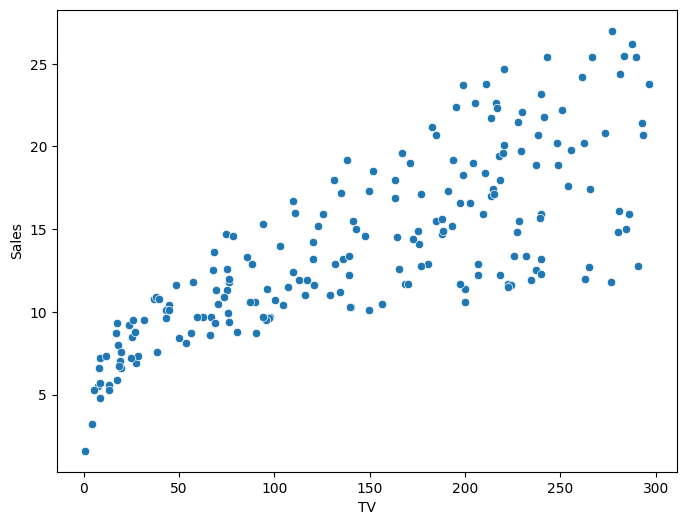

In [ ]:
sb.scatterplot(data=df, x='TV', y='Sales')

We'll assume that the relation between the feature $(x)$ and the output $(y)$ is linear by looking at the above graph.

### Train-Test Split

We'll split the data and will fit all scaling and transformation processes on thi training dataset not to cause any data leakage.

In [ ]:
x = df['TV']
y = df['Sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

# Training DataFrame
df_train = pd.DataFrame(columns=['TV', 'Sales'])
df_train['TV'] = x_train.reset_index(drop=True)
df_train['Sales'] = y_train.reset_index(drop=True)

# Testing DataFrame
df_test = pd.DataFrame(columns=['TV', 'Sales'])
df_test['TV'] = x_test.reset_index(drop=True)
df_test['Sales'] = y_test.reset_index(drop=True)
df_train.head()

,TV,Sales
0,67.8,12.5
1,139.5,10.3
2,96.2,11.4
3,18.8,7.0
4,76.4,11.8


### Checking for Noise (Outliers)

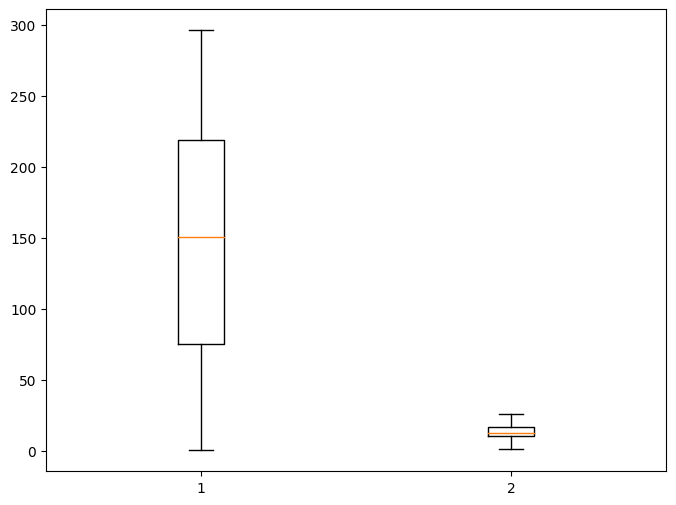

In [ ]:
plt.boxplot(df_train[['TV', 'Sales']])
plt.show()

As it can be shown on the graph above, there are no outliers in the training dataset.

### Removing Colinearity
As we have only one input, this process is not applicable for this dataset.

### Gaussian Distribution

<AxesSubplot: xlabel='Sales', ylabel='Density'>

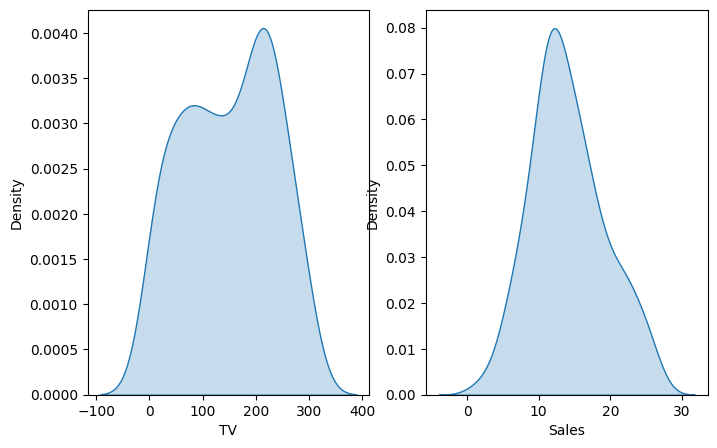

In [ ]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sb.kdeplot(data=df_train['TV'], fill=True)
plt.subplot(1, 2, 2)
sb.kdeplot(data=df_train['Sales'], fill=True)

As it can be seen from the above graph, output has more gaussian distribution while the input is not in that shape. We should transform the input accordingly.

In [ ]:
from sklearn.preprocessing import power_transform

df_transformed = df_train.copy()
df_transformed['TV'] = power_transform(df_transformed['TV'].values.reshape(-1,1), 
                                             method='yeo-johnson', standardize=True)
df_transformed.head()

,TV,Sales
0,-0.904647,12.5
1,-0.031356,10.3
2,-0.541055,11.4
3,-1.642544,7.0
4,-0.791360,11.8


<AxesSubplot: xlabel='TV', ylabel='Density'>

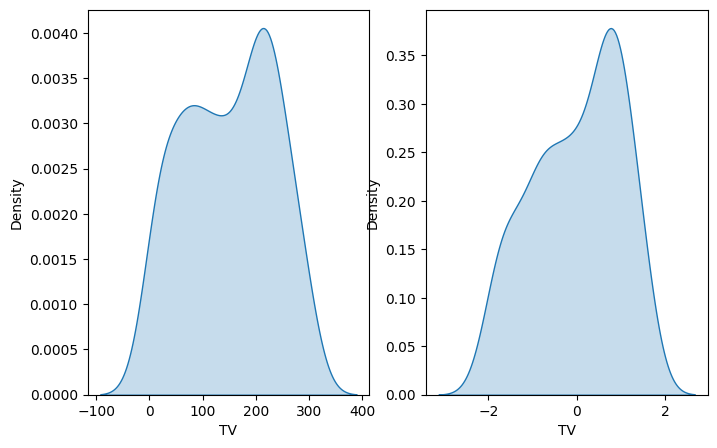

In [ ]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sb.kdeplot(data=df_train['TV'], fill=True)
plt.subplot(1, 2, 2)
sb.kdeplot(data=df_transformed['TV'], fill=True)

### Rescale Inputs

In [ ]:
df_transformed.describe()

,TV,Sales
count,1.600000e+02,160.000000
mean,1.276756e-16,14.097500
std,1.003140e+00,5.156811
min,-2.034587e+00,1.600000
25%,-8.037236e-01,10.675000
50%,9.349961e-02,13.200000
75%,8.175508e-01,17.325000
max,1.576891e+00,26.200000


We don't need to rescale inputs as it's standardized during the transformation process.

## Finding $b_0$ and $b_1$<a id='b0_b1'></a>

$$b_1 = \dfrac{\sum\limits_{i=1}^{n} ((x_i - mean(x) × (y_i - mean(y))}{\sum\limits_{i=1}^{n} (x_i - mean(x))^2}$$

<br /><br />
$$b_0 = mean(y) − b_1 × mean(x)$$

In [ ]:
def find_b0_b1(df):
    mean_x = df['TV'].mean()
    print('mean(x): ', mean_x)
    mean_y = df['Sales'].mean()
    print('mean(y): ', mean_y)
    df['TV-mean_x'] = df['TV'] - mean_x
    df['Sales-mean_y'] = df['Sales'] - mean_y
    df['Mult'] = df['TV-mean_x'] * df['Sales-mean_y']
    sum_mult = df['Mult'].sum()
    print('Sum of mutliplied x-mean(x) and y-mean(y): ', sum_mult)
    df['Squared'] = df['TV-mean_x'].pow(2)
    sum_sq = df_train['Squared'].sum()
    print('Sum of squared x-mean(x)', sum_sq)
    b1 = sum_mult / sum_sq
    print('b\N{SUBSCRIPT ONE}:', b1)
    
    b0 = mean_y - b1 * mean_x
    print('b\N{SUBSCRIPT ZERO}:', b0)

    return b0, b1

In [ ]:
b0, b1 = find_b0_b1(df_train)

mean(x):  149.43125
mean(y):  14.097500000000002
Sum of mutliplied x-mean(x) and y-mean(y):  54102.9925
Sum of squared x-mean(x) 1159080.5037500001
b₁: 0.046677510599962065
b₀: 7.122421244159421


## Predicting<a id='pred'></a>

### Calculating the Performance of Prediction

**Mean Absolute Error (MAE):** MAE is a measure of errors between paired observations such as predicted and actual values.
$$MAE = \frac{\sum_{i=1}^n|\hat{y_i} - y_i|}{n}$$


**Mean Squared Error (MSE):** MSE tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs.
$$MSE = \frac{\sum_{i=1}^n(\hat{y_i} - y_i)^2}{n}$$

The smaller the MSE and MAE is the better.

**RMSE**
$$ RMSE = \sqrt{\frac{\sum\limits_{i=1}^{n} (\hat{y_i} - y_i)^2}{n}} $$

**$R^2$:** A widely user measure that descibes how powerful a regression is. It's a relative measure adn takes values ranging from 0 to 1 and R squared of 0 means your regression line explains non of the variability of the data. 1 means your model explains the entire variability of the data.
There are 3 terms need to be defined before looking into R-squared:
1. **Sum of Squares Total (SST):** Also known as Total Sum of Squares (TSS).It's the observed square differences between the observed dependent variable and it's mean. It's the dispertion of the observed variables around the mean. <ins>Measures the total variablity of the dataset.</ins>
$$\sum_{i=1}^n(y_i - \overline{y})^2$$
2. **Sum of Squares Regression (SSR)**: Also known as Explain Sum of Squares (ESS). It's the sum of differences between the predicted value and the mean of the dependent variable. It's a measure that describes how well your line fits the data. <ins>Measures the explained variabilty by your line.</ins>
$$\sum_{i=1}^n(\hat{y} - \overline{y})^2$$

SSE = SST => The regression model captures all the observed variability and it's perfect.

3. **Sum of Squares Error (SSE)**: Also known as Residual (remaining or unexplained) Sum of Squares (RSS). It's the difference between observed value and the predicted value. <ins>Measures the unexplained variability by regression.</ins> The lower error, the better explanatory power of the regression.

$$\sum_{i=1}^ne_i^2$$

$SST = SSR + SST$: The total variability of the dataset is eqaul to the variablity explained by the regression line, plus the unexplained variability known as error.

$$R^2 = \frac{SSR}{SST}$$

In [ ]:
def test_b0_b1(df, b0, b1):
    df['Pred'] = b0 + b1*df['TV']
    df['error'] = df['Pred'] - df['Sales']
    df['sq_error'] = df['error'].pow(2)
    mae = df['error'].abs().sum() / len(df)
    mse = df['sq_error'].sum() / len(df)
    rmse = m.sqrt(mse)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    
    plt.scatter(df_test['TV'], df_test['Sales'])
    fig = plt.plot(df['TV'], df['Pred'], c='orange', label='Regression Line')
    plt.xlabel('TV', fontsize=14)
    plt.ylabel('Sales', fontsize=14)
    plt.show()

MAE: 6.694828715736745
MSE: 72.76576817110511
RMSE: 8.530285351094951


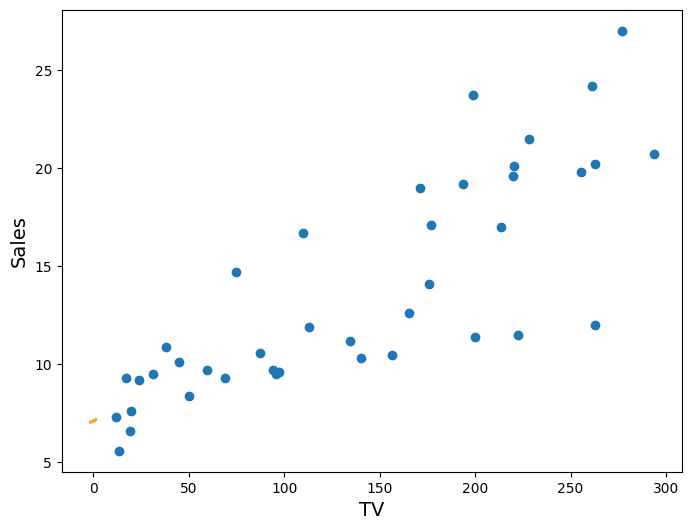

In [ ]:
df_tt = df_test.copy()
df_tt['TV'] = power_transform(df_test['TV'].values.reshape(-1,1), 
                                             method='yeo-johnson', standardize=True)

test_b0_b1(df_tt, b0, b1)

MAE: 2.4503287262775473
MSE: 10.025842933134657
RMSE: 3.1663611501429614


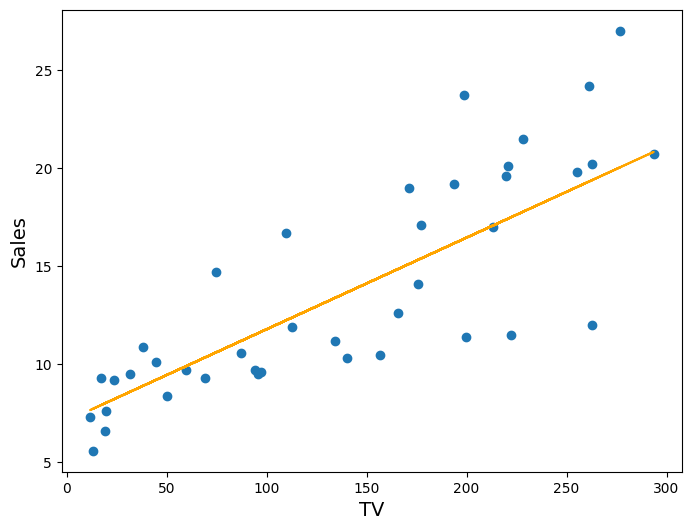

In [ ]:
test_b0_b1(df_test, b0, b1)

In [ ]:
# Training w/o power transform
find_b0_b1(df_train)

mean(x):  149.43125
mean(y):  14.097500000000002
Sum of mutliplied x-mean(x) and y-mean(y):  54102.9925
Sum of squared x-mean(x) 1159080.5037500001
b₁: 0.046677510599962065
b₀: 7.122421244159421


(7.122421244159421, 0.046677510599962065)

MAE: 2.4503287262775473
MSE: 10.025842933134657
RMSE: 3.1663611501429614


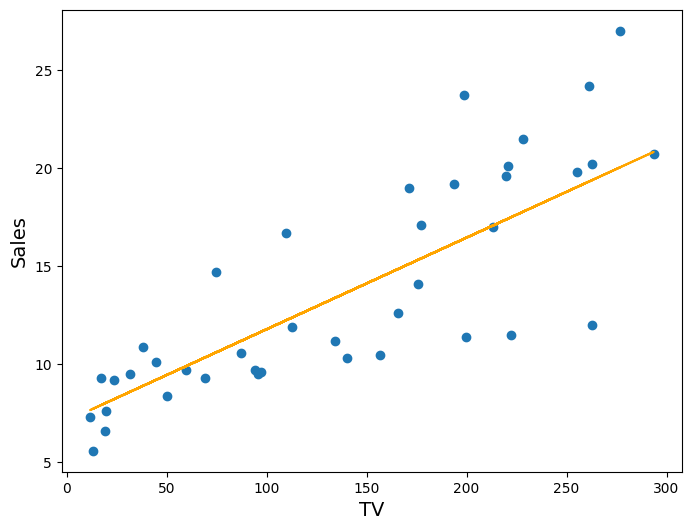

In [ ]:
# Testing w/o power transform
test_b0_b1(df_test, b0, b1)

## Finding $b_0$ and $b_1$ using OLS<a id='b0_b1_ols'></a>

OLS: Ordinay Least Squares
This procedure seeks to minimize the sum of the squared residuals. This means that given a regression line through the data we calculate the distance from each data point to the regression line, square it, and sum all of the squared errors together.

[Resource](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

In [ ]:
from sklearn import linear_model

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
print('b\N{SUBSCRIPT ONE}: ', reg.coef_)
print('b\N{SUBSCRIPT ZERO}: ', reg.intercept_)

b₁:  [[0.04667751]]
b₀:  [7.12242124]


MAE: 2.4503287262775473
MSE: 10.025842933134657
RMSE: 3.1663611501429614


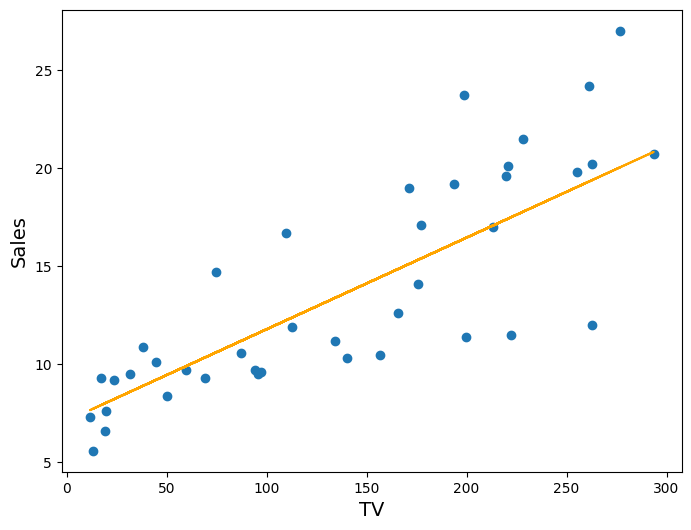

In [ ]:
test_b0_b1(df_test, reg.intercept_[0], reg.coef_[0])

## Finding $b_0$ and $b_1$ using Gradient Descent<a id='b0_b1_gd'></a>
In mathematics, gradient descent (also often called steepest descent) is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function[2].

$$coefficient = 0.0$$
$$cost = f(coefficient)$$
$$cost = evaluate(f(coefficient))$$
$$delta = derivative(cost)$$
$$coefficient = coefficient − (alpha × delta)$$

In [ ]:
nr_iterations = 60 # numer of iterations
errors = []
errors_2 = [] 
alpha = 0.01 # learning rate

b0 = 0
b1 = 0

j = 1
y = b0 + (b1 * df_train.loc[j, 'TV_Min'])
error = df_train.loc[j, 'Sales'] - y
errors.append(error)
errors_2.append(np.square(error))

for i in range(1, nr_iterations):
    if j == len(df_train):
        j = 1

    b0 = b0 - (alpha * error)
    b1 = b1 - (alpha * error * df_train.loc[j, 'TV_Min'])
    y = b0 + (b1 * df_train.loc[j+1, 'TV_Min'])
    error = df_train.loc[j+1, 'Sales'] - y
    errors.append(error)
    errors_2.append(np.square(error))
    j+=1
    
print('b\N{SUBSCRIPT ZERO}: ', b0)
print('b\N{SUBSCRIPT ONE}: ', b1)

b₀:  -11.9955056876079
b₁:  -6.717938283894848


MAE: 949.3505454946007
MSE: 1248557.106886487
RMSE: 1117.3885210107032


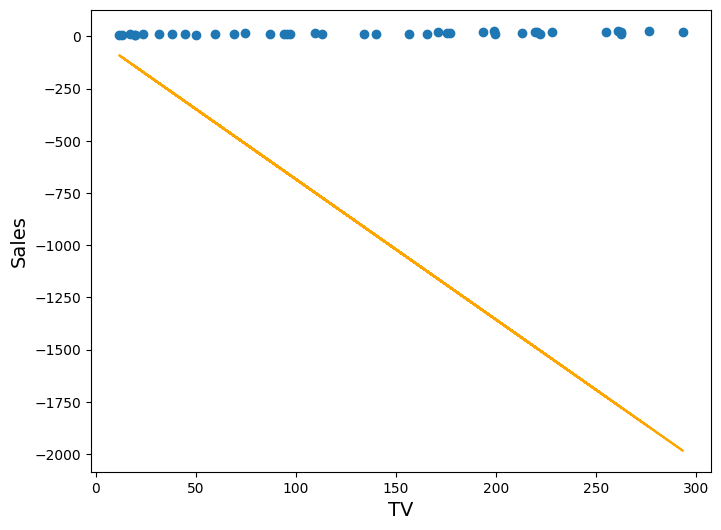

In [ ]:
df_test_min = df_test.copy()
df_test_min['TV_Min'] = scale.transform(df_test['TV'].values.reshape(-1,1))
test_b0_b1(df_test_min, b0, b1)

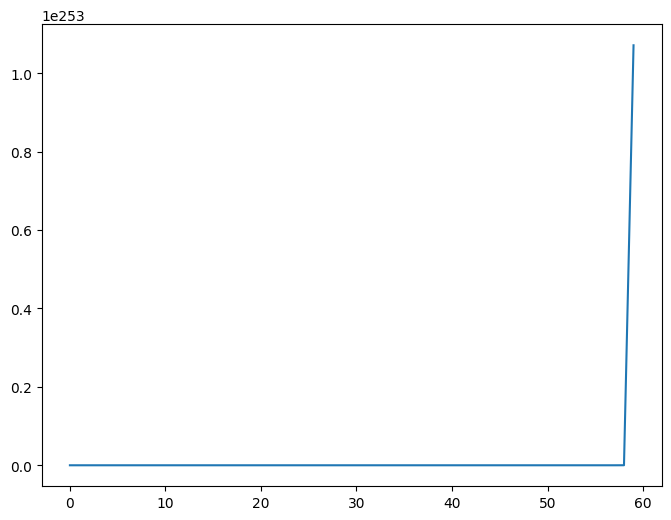

In [ ]:
plt.plot(errors_2)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
scale.fit(df_train['TV'].values.reshape(-1, 1))
df_train['TV_Min'] = scale.transform(df_train['TV'].values.reshape(-1, 1))

In [ ]:
df_train.head()

,TV,Sales,TV-mean_x,Sales-mean_y,Mult,Squared,TV_Min
0,67.8,12.5,-81.63125,-1.5975,130.405922,6663.660977,0.226919
1,139.5,10.3,-9.93125,-3.7975,37.713922,98.629727,0.469395
2,96.2,11.4,-53.23125,-2.6975,143.591297,2833.565977,0.322962
3,18.8,7.0,-130.63125,-7.0975,927.155297,17064.523477,0.061211
4,76.4,11.8,-73.03125,-2.2975,167.789297,5333.563477,0.256003


In [ ]:
df_test_min.head()

,TV,Sales,Pred,error,sq_error,TV_Min
0,74.7,14.7,-513.825495,-528.525495,2.793392e+05,0.250254
1,255.4,19.8,-1727.756943,-1747.556943,3.053955e+06,0.861346
2,112.9,11.9,-770.450738,-782.350738,6.120727e+05,0.379439
3,109.8,16.7,-749.625129,-766.325129,5.872542e+05,0.368955
4,31.5,9.5,-223.610562,-233.110562,5.434053e+04,0.104160


## References

[1] [Wikipedia](https://en.wikipedia.org/wiki/Linear_regression#cite_note-Freedman09-1)

[2] [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)